In [3]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('legend', fontsize=16)
matplotlib.rcParams['savefig.dpi'] = 1200
from utils_carryover import theta1, theta2
from utils_static_covariate import static_covariate
from utils_import_data import *
from utils_empirical import *

import pickle

%load_ext autoreload
%autoreload 2
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
color_palette_dict = get_color_palette()

In [15]:
out_dir = "../result/flu/"
out_path = out_dir 
save_path = out_dir + "flu_mse_varying_N.pkl"
Y = import_MS_FLU_pos_data()
tau_ratio = -0.1
lag = 2
all_taus = (1+lag - np.array(range(lag+1))); all_taus = all_taus/np.sum(all_taus); all_taus = list(np.mean(Y)*tau_ratio * all_taus)

all_taus = [4, -2, -1]; all_taus = all_taus/np.sum(all_taus); all_taus = list(np.mean(Y)*tau_ratio * all_taus)

# all_taus_null = [0]*(lag+1)
tau_total = np.mean(Y)*tau_ratio
adj_pct=0.02

In [16]:
with open(save_path, 'rb') as handle:
    summary = pickle.load(handle)
    
    
result_gls = summary['result_gls']
result_gls_var = summary['result_gls_var']
result_all_gls = summary['result_all_gls']
result_all_gls_var = summary['result_all_gls_var']

T = 7; N = 50; 
out_dict = result_gls[N]
out_total_dict = result_all_gls[N]
out_var_dict = result_gls_var[N]
out_total_var_dict = result_all_gls_var[N]

In [8]:
multiplier = 3
idx = 0; J = 1; G = 4; M = 1; sub_mc = int(len(result_gls[N]['ff'])/M)
thres_list = np.array(range(1000)) * 1e-2
# thres_list = np.array(range(150))/15
val1 = 50; val2 = 50; val3 = 50
max_thres_dict = {'ff': val1, 'ba': val1, 'ffba': val2, 'opt_0': val3, 
               'opt': val3, 'opt+_'+str(J)+'_'+str(G): val3}
tp_col = '$\mathrm{TPR~(power)}$'; fp_col = '$\mathrm{FPR~(significance~level)}$'; method_col = '$\mathrm{design}$'
method_dict = {'ff': '$Z_{\mathrm{ff}}$', 'ba': '$Z_{\mathrm{ba}}$', 'ffba': '$Z_{\mathrm{ffba}}$', 'opt_0': '$Z_{\mathrm{opt,linear}}$', 
               'opt': '$Z_{\mathrm{opt}}$', 'opt+_'+str(J)+'_'+str(G): '$Z_{\mathrm{opt,stratified}}$'}


z_value_dict = dict()
null_z_value_dict = dict()
for name in ['ff', 'ba', 'ffba', 'opt_0','opt', 'opt+_'+str(J)+'_'+str(G)]:
    this_z_value = np.zeros_like(np.array(out_dict[name]))
    this_null_z_value = np.zeros_like(np.array(out_dict[name]))
    

    this_z_value = (out_dict[name] - np.array(all_taus[::-1]) + multiplier*np.mean(all_taus))/np.sqrt(out_var_dict[name])
    this_null_z_value = (np.array(out_dict[name]) - np.array(all_taus[::-1]))/np.sqrt(out_var_dict[name])
    z_value_dict[name] = this_z_value
    null_z_value_dict[name] = this_null_z_value


out = dict()
out[tp_col] = list()
out[fp_col] = list()
out[method_col] = list()



# for name in ['ff', 'ba', 'ffba', 'opt']:
for name in ['ff', 'ba', 'ffba', 'opt_0', 'opt', 'opt+_'+str(J)+'_'+str(G)]:
    tp_list = list()
    fp_list = list()
    for thres in thres_list:
        for m in range(M):
            if thres < max_thres_dict[name]:
                tp = np.sum(np.absolute(np.array(z_value_dict[name][(m*sub_mc):((m+1)*sub_mc),idx])) > thres)
                fp = np.sum(np.absolute(np.array(null_z_value_dict[name][(m*sub_mc):((m+1)*sub_mc),idx])) > thres)
                tp_list.append(tp/sub_mc)
                fp_list.append(fp/sub_mc)
    out[tp_col] = out[tp_col] + tp_list
    out[fp_col] = out[fp_col] + fp_list
    out[method_col] = out[method_col] + [method_dict[name]] * len(fp_list)

out_df = pd.DataFrame(out)

out_df = out_df.loc[out_df[fp_col] <= 0.1, ]

In [10]:
out_df

,$\mathrm{TPR~(power)}$,$\mathrm{FPR~(significance~level)}$,$\mathrm{design}$
927,0.2690,0.0990,$Z_{\mathrm{ff}}$
928,0.2685,0.0985,$Z_{\mathrm{ff}}$
929,0.2680,0.0985,$Z_{\mathrm{ff}}$
930,0.2680,0.0985,$Z_{\mathrm{ff}}$
931,0.2680,0.0985,$Z_{\mathrm{ff}}$
...,...,...,...
995,0.2455,0.0830,$Z_{\mathrm{ff}}$
996,0.2455,0.0830,$Z_{\mathrm{ff}}$
997,0.2455,0.0830,$Z_{\mathrm{ff}}$
998,0.2445,0.0830,$Z_{\mathrm{ff}}$


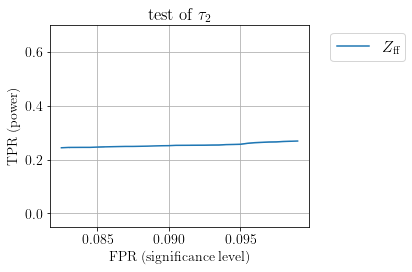

In [9]:
out_path = "./extensions/20220107-varying_N/"
if idx == 0:
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4))
else:
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))
# sns.scatterplot(data=out_df, x=fp_col, y=tp_col, hue=method_col, palette=color_palette_dict,s=4,linewidth=0, alpha = 1)
sns.lineplot(data=out_df, x=fp_col, y=tp_col, hue=method_col, palette=color_palette_dict)

ax.tick_params('x', labelrotation=360)
ax.set_xlabel(fp_col)
ax.set_ylabel(tp_col)
ax.set_ylim([-0.05,0.7])
# ax.set_xlim([-0.05,0.1])
if idx == 0:
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',markerscale=0.5)
else:
    plt.legend('',frameon=False)
plt.title("$\mathrm{test~of~}\\tau_"+str(lag-idx)+"$")
plt.grid()
plt.tight_layout()
# plt.savefig(out_path+"N_"+str(N)+"_T_"+str(T)+"_lag_"+str(lag)+"_"+str(tau_ratio)+"_tau"+str(lag-idx)+"_roc_equal_tau-line-plot.pdf")

In [11]:
auc_dict = dict(); 
auc_dict['auc'] = list()
auc_dict['idx'] = list()
auc_dict['method'] = list()

In [12]:
all_names = ['ff', 'ba', 'ffba', 'opt_0', 'opt', 'opt+_'+str(J)+'_'+str(G)]

interval = 0.001; num_intervals = int(1/interval)
auc_dict['idx'] += [lag- idx] * len(all_names)
auc_list = list()
method_list = list()
for name in all_names:
    sub_df = out_df[out_df[method_col] == method_dict[name]]
    auc = 0
    for j in range(num_intervals):
        left_end_point = j * interval
        right_end_point = (j+1) * interval
        indicator = (sub_df[fp_col] > left_end_point) & (sub_df[fp_col] <= right_end_point)
        if np.sum(indicator) == 0:
            auc += interval * (left_end_point + right_end_point)/2
        else:
            auc += interval * np.mean(sub_df[indicator][tp_col])
    auc_list.append(auc)
    method_list.append(method_dict[name])
auc_dict['auc'] += auc_list
auc_dict['method'] += method_list

In [17]:
auc_df = pd.DataFrame(auc_dict)

auc_df_pt = pd.pivot_table(auc_df, values='auc', columns='idx', index='method').T.iloc[:,[2,0,1,5,3,4]]

auc_df_pt.to_latex(out_path+"auc.tex", float_format="%.3f" )

In [14]:
out_path

'./extensions/20220107-varying_N/'